# About

This script generates the numerical plots for the 2-dim Kuramoto system with adaptive delays, with varying initial points.
The purpose is to show the numerical basin of attraction around each stable synchronous point. All trials are performed in MATLAB. The MATLAB script is found in 'sec4_2D_numerics.mat'

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files from Matlab
import_folder = 'sec4_2D_numerics' # 'sec4_2D_numerics1'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)
filenames.remove('parameters.mat')

# Import and compile data

## Parameters

In [3]:
dir_par = os.path.join(dir_im, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

Omega0_arr = np.reshape(dict_par['Omega0'], -1)
Delta0_arr = np.reshape(dict_par['Delta0'], -1)

g = dict_par['g'][0,0]
gain = dict_par['gain'][0,0]
w0 = dict_par['omega0'][0,0]
tau0 = dict_par['tau0'][0,0]

# t0 = dict_par['t0'][0,0]
tf = dict_par['tf'][0,0]

# Asymptotic percentage
asy = 0.1

## Theoretical states

In [4]:
parameters = {'g': g, 'gain': gain, 'omega0': w0, 'tau0': tau0}
Omegafun = funlib.Omega2D(parameters)

# Get all roots of Omega_fun in region
Omegaroots = rootlib.root_on_interval(Omegafun, w0-g, w0+g, steps=1000)
Omegaroots = np.sort(Omegaroots)
Deltaroots = np.arcsin((w0 - Omegaroots)/g)

## Import data

In [5]:
# Compile arrays
Delta0_mesh, Omega0_mesh = np.meshgrid(Delta0_arr, Omega0_arr)
asy_mesh = np.empty(Omega0_mesh.shape)
asy_mesh[:] = np.nan

# Which trial to plot (Delta0, Omega0)
ind_plot1 = (1, 2)
ind_plot2 = (2, 1)

# Tolerance
tol = 0.1

# Acquire trials data
for i in range(len(filenames)):
    
    # Import .mat file
    filename = filenames[i]
    dir_mat = os.path.join(dir_im, filename)
    dict_mat =  sio.loadmat(dir_mat)
    
    # Get g, tau0 indices
    inds_file = filename.split('.')[0]
    ind_Delta0, ind_Omega0 = inds_file.split('_')
    ind_Delta0 = int(ind_Delta0)
    ind_Omega0 = int(ind_Omega0)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau']
          }
    
    # Compute the global frequency:
    arrOmega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asyOmega = np.sum(arrOmega) / arrOmega.size
    
    # Get array of phases
    arrLinear = asyOmega*sol['t']
    arrLinear = arrLinear[:,None]

    arrPhases = sol['y'] - arrLinear
    asyPhases = asylib.weight_avg(sol['t'], arrPhases, asy)
    asyDelta = np.abs(asyPhases[1] - asyPhases[0])
    sol['phases'] = arrPhases
    
    # Get distance from each:
    dists = np.sqrt((asyOmega - Omegaroots)**2 + (asyDelta - Deltaroots)**2)
    ind_min = np.argmin(dists)
    
    if dists[ind_min] < tol:
        asy_mesh[ind_Omega0, ind_Delta0] = ind_min
        
    # Store solution
    if ind_Omega0 == ind_plot1[0] and ind_Delta0 == ind_plot1[1]:
        sol1 = sol.copy()
        sol1['Omega0'] = dict_mat['Omega0'][0,0]
        sol1['Delta0'] = dict_mat['Delta0'][0,0]
        sol1['asyOmega'] = asyOmega
        sol1['asyDelta'] = asyDelta
        sol1['phases'] = arrPhases
    
    elif ind_Omega0 == ind_plot2[0] and ind_Delta0 == ind_plot2[1]:
        sol2 = sol.copy()
        sol2['Omega0'] = dict_mat['Omega0'][0,0]
        sol2['Delta0'] = dict_mat['Delta0'][0,0]
        sol2['asyOmega'] = asyOmega
        sol2['asyDelta'] = asyDelta
        sol2['phases'] = arrPhases

# Plot

## Options

In [15]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.05, 0.7, 0.45, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.05, 0.4, 0.45, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.05, 0.1, 0.45, 0.20] # Fig 2c: Delay plots
bbox3 = [0.60, 0.1, 0.40, 0.80] # Fig 2d: Basin plot

# Line options
options_w0 = {'color': 'green',
              'linewidth': 0.5,
              'alpha': 0.8,
              }

options_asy = {'color': 'orange',
               'linewidth': 0.5,
               'alpha': 0.8,
               }

# Colourmap options
cmap = 'YlOrRd'
levels = np.unique(asy_mesh[~np.isnan(asy_mesh)])
levels = np.append(levels, 0)
levels = np.sort(levels)

# Plot function
def plot_sol(ax1, ax2, ax3, sol, trial=1):
    '''
    Plots the frequency, phase diff, delay arrays to ax1, ax2, ax3 respectively. Uses different options for trials 1 or 2
    '''
    
    # Solution arrays
    t = sol['t']
    y = sol['phases']
    yp = sol['yp']
    tau = sol['tau']
    
    # Line options
    ls1 = (0, (5,1))
    ls2 = (1, (1,1))
    alpha = 0.9
    
    if trial == 1:
        color = 'blue'
    else:
        color = 'orange'
    
    ax1.plot(t, yp[:,0], color=color, linestyle=ls1, alpha=alpha, zorder=1)
    ax2.plot(t, np.sin(y[:,0]), color=color, linestyle=ls1, alpha=alpha, zorder=1)
    ax3.plot(t, tau[:,0], color=color, linestyle=ls1, alpha=alpha, zorder=1)
               
    ax1.plot(t, yp[:,1], color=color, linestyle=ls2, alpha=alpha, zorder=1)
    ax2.plot(t, np.sin(y[:,1]), color=color, linestyle=ls2, alpha=alpha, zorder=1)
    ax3.plot(t, tau[:,1], color=color, linestyle=ls2, alpha=alpha, zorder=1) 
    
    # Adjust the plots
    tmin = np.min(t)
    tmax = np.max(t)
    
    ax1.set_xlim(left=tmin, right=tmax)
    ax2.set_xlim(left=tmin, right=tmax)
    ax3.set_xlim(left=tmin, right=tmax)

## Generate figure

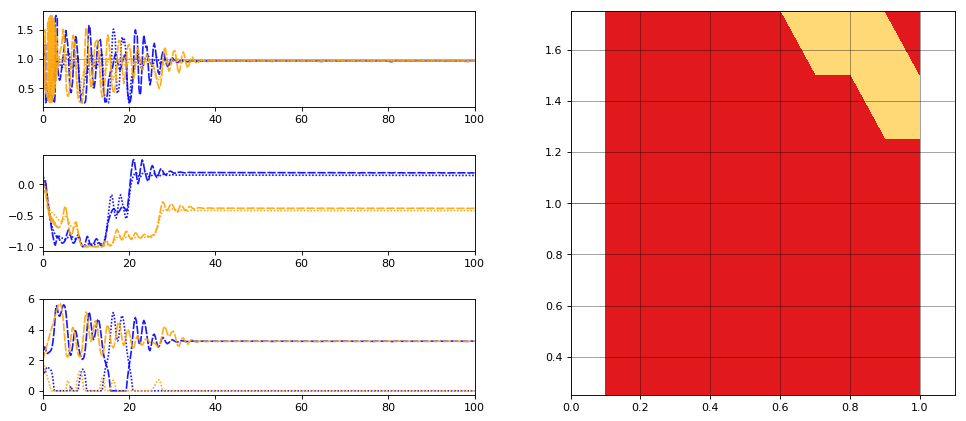

In [20]:
fig, ax = plt.subplots(4, figsize=(12,6), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Trials:
plot_sol(ax[0], ax[1], ax[2], sol1, trial=1)
plot_sol(ax[0], ax[1], ax[2], sol2, trial=2)

# Colourmap
ax[3].contourf(Delta0_mesh, Omega0_mesh, asy_mesh, levels, cmap=cmap)
ax[3].grid(b=True, which='both', color='black', alpha=0.4, zorder=-1)

# Put markerpoints as well.

# Axis lines
ax[0].axhline(y=w0, zorder=0, **options_w0)
ax[3].axhline(y=w0, zorder=0, **options_w0)

## Statistics

In [8]:
Omega0_1 = sol1['Omega0']
Delta0_1 = sol1['Delta0']
Omega0_2 = sol2['Omega0']
Delta0_2 = sol2['Delta0']
asyOmega1 = sol1['asyOmega']
asyOmega2 = sol2['asyOmega']
print(f'Trial 1: \n Omega0 = {Omega0_1} \n Delta0 = {Delta0_1} \n asyOmega = {asyOmega1}')
print(f'Trial 2: \n Omega0 = {Omega0_2} \n Delta0 = {Delta0_2} \n asyOmega = {asyOmega2}')

Trial 1: 
 Omega0 = 0.5 
 Delta0 = 0.2 
 asyOmega = 0.9679456207674273
Trial 2: 
 Omega0 = 0.75 
 Delta0 = 0.1 
 asyOmega = 0.9688905411054339


In [9]:
np.unique(asy_mesh)

array([ 2.,  4., nan, nan, nan, nan, nan, nan, nan])

In [12]:
asy_mesh

array([[nan,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [nan,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  2.],
       [nan,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [nan,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [nan,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  2.,  2.],
       [nan,  4.,  4.,  4.,  4.,  4.,  4.,  2.,  2.,  2.,  2.],
       [nan,  4.,  4.,  4.,  4.,  2.,  2.,  2.,  2.,  2.,  4.]])